In [236]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import glob
from sklearn.decomposition import PCA

import sys
sys.path.append("../../ibl_analyses/")
sys.path.append("../../siegel_analyses/scripts/")
import netrep_helpers as nh
import utils
from sklearn.manifold import MDS
from scikits.bootstrap import bootstrap as bt
from scipy.stats import ttest_ind
import tqdm
import seaborn as sns
from netrep.metrics import LinearMetric
from netrep.utils import whiten, angular_distance

import imp
imp.reload(utils)
from netrep.multiset import frechet_mean as fm
from netrep.utils import align
import matplotlib as mpl
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)

In [237]:
sessions_1 = glob.glob('../Dataset_1/*')
sessions_2 = glob.glob('../Dataset_2/*')
sessions_3 = glob.glob('../Dataset_3/*')

sessions = sessions_1 + sessions_2 #+ sessions_3

In [238]:


HD_neuron_fold = []


n_folds = 20

n_pcs = 20
pca = PCA(n_components=n_pcs)

brain_areas = []
total_neurons = []
for session in tqdm.tqdm(sessions):

    hd_data = loadmat(session + '/Analysis/HdTuning_xval_moveEp.mat')
    hd_data_1 = hd_data["hAll1"] # last index is smoothing window. 12 seems grea
    hd_data_2 = hd_data["hAll2"]


    total_neurons.append(hd_data_1.shape[1])
    N = len(hd_data_1[0])
    idx = np.arange(N)
    many_folds = []
    many_folds_rough = []
    for fold in range(n_folds):

        np.random.shuffle(idx)
        pca_fit = pca.fit(hd_data_1[:,idx[:N//2],12])
        
        pcs_1 = pca_fit.transform(hd_data_1[:,idx[:N//2],12])   
        pcs_2 = pca_fit.transform(hd_data_2[:,idx[:N//2],12])

        many_folds.append([pcs_1,pcs_2])
    
    HD_neuron_fold.append(many_folds)


sh = np.shape(HD_neuron_fold)
HD_many_neuron_fold = np.array(HD_neuron_fold).transpose(1,0,2,3,4).reshape(sh[1],-1,sh[3],sh[4])
HD_neuron_fold  = HD_many_neuron_fold[0]


  0%|          | 0/31 [00:00<?, ?it/s]

100%|██████████| 31/31 [00:38<00:00,  1.25s/it]


In [239]:
S=len(sessions)
print(S)

S_tot = len(HD_neuron_fold)
print(S_tot)

31
62


In [240]:

# data = HD_neuron_fold
# Xbar,Xs_aligned = fm(data,return_aligned_Xs=True,tol=1e-100,method='full_batch',max_iter=100)
# pca = PCA(n_components=20).fit(Xbar)
# Xs_aligned_low = np.array([pca.transform(X) for X in Xs_aligned])
# plt.plot(np.mean(Xs_aligned_low,0)[:,0],np.mean(Xs_aligned_low,0)[:,1],color='darkblue',lw=4)
# [plt.plot(Xs_aligned_low[i][:,0],Xs_aligned_low[i][:,1],alpha=0.1,color="gray") for i in range(len(Xs_aligned))]

# plt.axis('equal')
# plt.axis('off')

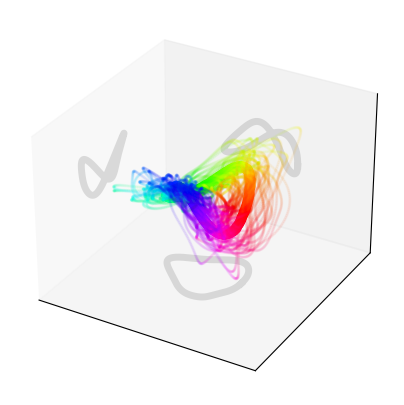

In [241]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')


data = HD_many_neuron_fold[1]
Xbar,Xs_aligned = fm(data,return_aligned_Xs=True,tol=1e-100,method='full_batch',max_iter=100)
pca = PCA(n_components=20).fit(Xbar)
Xs_aligned_low = np.array([pca.transform(X) for X in Xs_aligned])

Xs_aligned_m = Xs_aligned_low.mean(0) - Xs_aligned_low.mean(0).mean(0)

colors = colors = sns.color_palette("hsv", 360)



[ax.plot(Xs_aligned_m[i,0],Xs_aligned_m[i,1],Xs_aligned_m[i,2],"o",color=colors[i],lw=4,clip_on=False) for i in range(360)]

[ax.scatter(Xs_aligned_low[:,i,0],Xs_aligned_low[:,i,1],Xs_aligned_low[:,i,2],s=2,alpha=0.05,color=colors[i],clip_on=False) for i in range(360)]
ax.set_xlim(np.array(ax.get_xlim())*0.75)
ax.set_ylim(np.array(ax.get_ylim())*0.75)
ax.set_zlim(np.array(ax.get_zlim())*0.75)

z=ax.get_zlim()[0]
z=-65
ax.plot(Xs_aligned_m[:,0],Xs_aligned_m[:,1],z,color='gray',lw=5,alpha=0.25,clip_on=False)
#ax.plot(Xs_aligned_low[:,:,0],Xs_aligned_low[:,:,1],z,alpha=0.2,color="gray")


y=ax.get_ylim()[-1]
y=65
ax.plot(Xs_aligned_m[:,0],y,Xs_aligned_m[:,2],color='gray',lw=5,alpha=0.25,clip_on=False)
#ax.plot(Xs_aligned_low[:,:,0],y,Xs_aligned_low[:,:,2],alpha=0.2,color="gray")


x=ax.get_xlim()[0]
x=-65
ax.plot(x,Xs_aligned_m[:,1],Xs_aligned_m[:,2],color='gray',lw=5,alpha=0.25,clip_on=False)
#ax.plot(x,Xs_aligned_low[:,:,1],Xs_aligned_low[:,:,2],alpha=0.2,color="gray") 


ax.set_xlim(-65,65)
ax.set_ylim(-65,65)
ax.set_zlim(-65,65)

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
# ax.set_xlabel("PC1")
# ax.set_ylabel("PC2")
# ax.set_zlabel("PC3")
plt.savefig("../results/3D_aligned.png",bbox_inches='tight',dpi=300)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
zlim = ax.get_zlim()

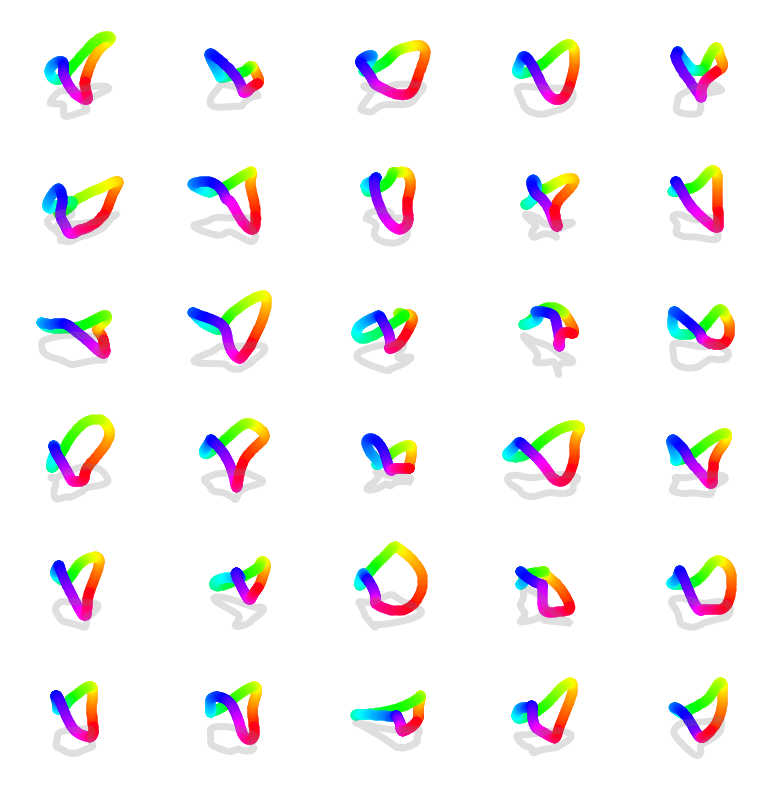

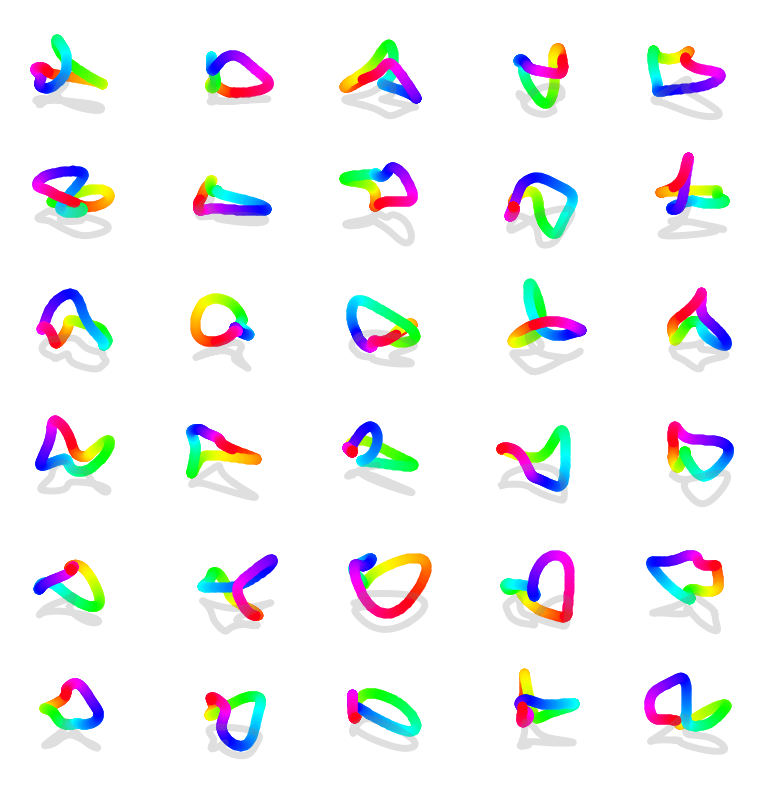

In [284]:
fig = plt.figure(figsize=(10,10))

for xi,x in enumerate(range(0,S_tot-2,2)):
    X = Xs_aligned_low[x]
    ax = fig.add_subplot(6,5,xi+1 ,projection='3d')

    [ax.plot(X[i,0],X[i,1],X[i,2],"o",color=colors[i],lw=4,clip_on=False) for i in range(360)]


    z=ax.get_zlim()[0]
    ax.plot(X[:,0],X[:,1],z*1.5,color='gray',lw=5,alpha=0.25,clip_on=False)
    ax.axis('off')
    plt.axis('equal')
    plt.subplots_adjust(wspace=0, hspace=0)

plt.savefig("../results/3D_aligned_individual.pdf",bbox_inches='tight')

fig = plt.figure(figsize=(10,10))

for xi,x in enumerate(range(0,S_tot-2,2)):
    X = HD_many_neuron_fold[0][x]
    ax = fig.add_subplot(6,5,xi+1 ,projection='3d')

    [ax.plot(X[i,0],X[i,1],X[i,2],"o",color=colors[i],lw=4,clip_on=False) for i in range(360)]


    z=ax.get_zlim()[0]
    ax.plot(X[:,0],X[:,1],z*1.5,color='gray',lw=5,alpha=0.25,clip_on=False)
    ax.axis('off')
    plt.axis('equal')
    plt.subplots_adjust(wspace=0, hspace=0)

plt.savefig("../results/3D_not_aligned_individual.pdf",bbox_inches='tight')


In [242]:
# import numpy as np
# from ripser import Rips

# rips = Rips()
# diagrams = rips.fit_transform(Xbar)
# rips.plot(diagrams)

# plt.figure()
# rips = Rips()
# diagrams = rips.fit_transform(np.array(Xs_aligned[0]))
# rips.plot(diagrams)

In [243]:

# Xbar,Xs_aligned = fm(data,return_aligned_Xs=True,tol=1e-100,method='full_batch',max_iter=100)

# explained_variance_in_aligned_space = []
# for c in range(1,21):
#     pca = PCA(n_components=c).fit(Xbar)
#     Xs_aligned_low = np.array([pca.transform(X) for X in Xs_aligned])
#     Xs_aligned_high = np.array([pca.inverse_transform(X) for X in Xs_aligned_low])

#     explained_variance = []
#     for i in range(len(Xs_aligned_high)):
#         var = 1-np.linalg.norm(Xs_aligned[i] - Xs_aligned_high[i])/np.linalg.norm(Xs_aligned[i])
#         explained_variance.append(var)
    
#     explained_variance_in_aligned_space.append(explained_variance)

# explained_variance_in_original_space = [np.cumsum(PCA(n_components=20).fit(X).explained_variance_ratio_) for X in data]



In [244]:
# plt.figure(figsize=(1.5,1.5))
# ax = fig.add_subplot(111)

# ax=plt.errorbar(range(1,21),np.mean(explained_variance_in_original_space,0),np.std(explained_variance_in_original_space,0),clip_on=False,label='original PCs')
# plt.errorbar(range(1,21),np.mean(explained_variance_in_aligned_space,1),np.std(explained_variance_in_aligned_space,1),clip_on=False,label='aligned PCs',color='darkblue')

# plt.xlim(0,20)
# plt.ylim(0,1)
# sns.despine()
# #plt.gca().set_yscale('log')
# xlabels = ['']*20
# xlabels[0] = '1'
# xlabels[19] = '20'
# plt.xticks([1,20])
# plt.ylabel("%")
# plt.xlabel("PCs")
# plt.title('explained variance of \noriginal data')
# plt.yticks([0,.5,.9,1],[0,'',90,100])
# plt.plot([0,20],[.90,.90],'-',color='gray',alpha=0.5)
# plt.legend(frameon=False)
# # change font color of legend
# leg = plt.gca().get_legend()
# ltext  = leg.get_texts()

# plt.setp(ltext[1], color='darkblue')
# plt.setp(ltext[0], color=ax[-1][0].get_color())
# plt.savefig("../results/aligned_explained_variance.svg",bbox_inches='tight')

In [245]:
# Xbar_1 = fm(data,return_aligned_Xs=False,tol=1e-100,method='full_batch',max_iter=100)
# all_Xbar = [Xbar_1]
# for data in tqdm.tqdm(HD_many_neuron_fold[1:]):
#     Xbar,Xs_aligned = fm(data,return_aligned_Xs=True,tol=1e-100,method='full_batch',max_iter=100)
#     Xbar = Xbar @ align(Xbar,Xbar_1)
#     all_Xbar.append(Xbar)


In [246]:
# pca = PCA(n_components=20).fit(all_Xbar[0])
# all_Xbar_pcs = np.array([pca.transform(Xbar) for Xbar in all_Xbar])

# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(122, projection='3d')
# Xbar_mean = np.mean(all_Xbar_pcs,0)
# [plt.plot(Xbar_mean[i,0],Xbar_mean[i,1],Xbar_mean[i,2],"o",color=colors[i],lw=4) for i in range(360)]
# [plt.plot(Xbar_mean[i,0],Xbar_mean[i,1],Xbar_mean[i,2],"o",color=colors[i],lw=4) for i in range(360)]

# z=ax.get_zlim()[0]*1.5
# ax.plot(Xbar_mean[:,0],Xbar_mean[:,1],z*np.ones_like(Xbar_mean[:,0]),color='gray',lw=5,alpha=0.25)

# y=ax.get_ylim()[-1]*1.5
# ax.plot(Xbar_mean[:,0],y,Xbar_mean[:,2],color='gray',lw=5,alpha=0.25)

# x=ax.get_xlim()[0]*1.5
# ax.plot(x,Xbar_mean[:,1],Xbar_mean[:,2],color='gray',lw=5,alpha=0.25)
# plt.axis('equal')


# prediction

In [247]:
from numpy import random
from sklearn.linear_model import LinearRegression

def get_landmarks(n_landmarks,w_tol=6):
    
    if landmarks == 0: 
        # nothing is aligned - decoding on unaliged data
        idx_landmarks = np.zeros(360).astype(bool)
        idx_landmarks_tol  = idx_landmarks.copy()
        return idx_landmarks,idx_landmarks_tol
        
    idx_landmarks_ = np.array(np.linspace(0,360,n_landmarks,endpoint=False),dtype=int)
    idx_landmarks = np.zeros(360).astype(bool)
    idx_landmarks[idx_landmarks_] = True
    random_roll = random.randint(0,360)
    idx_landmarks = np.roll(idx_landmarks,random_roll)
    
    # remove points around landmarks from training data 
    # to avoid overfitting due to smoothing
    idx_landmarks_tol = np.zeros(360).astype(bool)
    for i in np.where(idx_landmarks)[0]:
        beg = i-w_tol
        end = i+w_tol

        # account for the edges
        if beg < 0: 
            idx_landmarks_tol[beg:] = True
            beg = 0
        if end >= 360:
            end -= 360
            idx_landmarks_tol[:end] = True
            end = 359
            
        idx_landmarks_tol[beg:end+1] = True
    
    return idx_landmarks,idx_landmarks_tol

def run_one_foundation(fold,n_landmarks,n_subejcts):

    data_fold1 = fold[range(0,S_tot,2)]
    data_fold2 = fold[range(1,S_tot,2)]
    
    idx_landmarks,idx_landmarks_tol = get_landmarks(n_landmarks)

    # get alignments using landmarks
    Xbar_1 = fm(data_fold1[:,idx_landmarks],return_aligned_Xs=False,tol=1e-100,method='full_batch',max_iter=100)
    # rotate all data (including non seen landmarks)
    all_aligns = np.array([data_fold2[xi] @ align(X[idx_landmarks],Xbar_1) for xi,X in enumerate(data_fold1)])
            
    # get the angles of all the landmarks that were not used for alignment
    train_cond = np.where(~idx_landmarks_tol)[0]
    
    # take max 100 conditions for decoding to make a fair comparison
    # (alignments with more landmarks will have less conditions to train)
    np.random.shuffle(train_cond)
    train_cond = train_cond[:100] 
    x_test = np.cos(np.deg2rad(train_cond))
    y_test = np.sin(np.deg2rad(train_cond))

    # train on N subjects, test on left out subject
    idx = np.arange(S)
    scores = np.zeros(S)

    for s in range(S):
        # leave one subject out
        train_subj = np.where(idx != s)[0]
        data_test = all_aligns[s,train_cond]

        # train on a random subject of subjects
        np.random.shuffle(train_subj)
        train_subj = train_subj[:n_subejcts]

        # training labels (repeated for all training subjects)
        all_train_cond = np.array(list(train_cond)*(len(train_subj)))
        x_train = np.cos(np.deg2rad(all_train_cond))
        y_train = np.sin(np.deg2rad(all_train_cond))

        # falatten the data as if every trials comes from the same mega subject
        data_train = all_aligns[train_subj][:,train_cond].reshape(-1,20)

        # decoding x and y separately to account for circularity
        lreg = LinearRegression().fit(data_train,x_train)
        x_score = lreg.score(data_test,x_test)

        lreg = LinearRegression().fit(data_train,y_train)
        y_score = lreg.score(data_test,y_test)

        scores[s]=x_score/2 + y_score/2
    
    return scores

def run_one_baseline(fold,shuffle=False):
    data_fold1 = fold[range(0,S_tot,2)]
    data_fold2 = fold[range(1,S_tot,2)]


    train_cond = np.arange(360) 
    # take max 100 conditions for decoding to make a fair comparison
    # (alignments with more landmarks will have less conditions to train)
    np.random.shuffle(train_cond)
  #  train_cond = train_cond[:100] 
    x = np.cos(np.deg2rad(train_cond))
    y = np.sin(np.deg2rad(train_cond))

    if shuffle:
        np.random.shuffle(x)
        np.random.shuffle(y)

    scores = np.zeros(S)
    # train and test on same subject
    for s in range(S):

        # decoding x and y separately to account for circularity
        lreg = LinearRegression().fit(data_fold1[s,train_cond],x)
        x_score = lreg.score(data_fold2[s,train_cond],x)

        lreg = LinearRegression().fit(data_fold1[s,train_cond],y)
        y_score = lreg.score(data_fold2[s,train_cond],y)

        scores[s]=x_score/2 + y_score/2
    
    return scores

In [248]:
N_landmarks = range(2,20,2)
N_subjects = [1,2,3,4,5,6,12,24,30]
all_foundations = np.zeros((S,n_folds,len(N_subjects),len(N_landmarks)))
all_baselines = np.zeros((S,n_folds))

for fi,fold in enumerate(tqdm.tqdm(HD_many_neuron_fold)):
    all_baselines[:,fi] = run_one_baseline(fold)
    for li,landmarks in enumerate(N_landmarks):
        for ni,N in enumerate(N_subjects):
            all_foundations[:,fi,ni,li] = run_one_foundation(fold,landmarks,N)


100%|██████████| 20/20 [19:37<00:00, 58.86s/it]


In [249]:
all_baselines.shape
np.std(np.median(all_baselines,1),0)

0.4067437442656816

In [250]:
n_shuffles = 100
shuffle_baselines = np.zeros((S,n_shuffles))

for si in tqdm.trange(n_shuffles):
    shuffle_baselines[:,si] = run_one_baseline(fold,shuffle=True)




100%|██████████| 100/100 [00:10<00:00,  9.24it/s]


In [251]:
# idx_landmarks,idx_landmarks_tol = get_landmarks(10,w_tol=1)
# idx_landmarks_tol_ = np.radians(np.where(idx_landmarks_tol)[0])

# plt.plot(np.cos(idx_landmarks_tol_),np.sin(idx_landmarks_tol_),'o',color='red',alpha=0.5)
# plt.plot(np.cos(np.radians(np.where(idx_landmarks)[0])),np.sin(np.radians(np.where(idx_landmarks)[0])),'*')
# plt.axis('equal')
# Xbar_1 = fm(data_fold1[:,idx_landmarks],return_aligned_Xs=False,tol=1e-100,method='full_batch',max_iter=100)



In [252]:
np.median(all_foundations,1).shape

(31, 9, 9)

(2.0, 18.0)

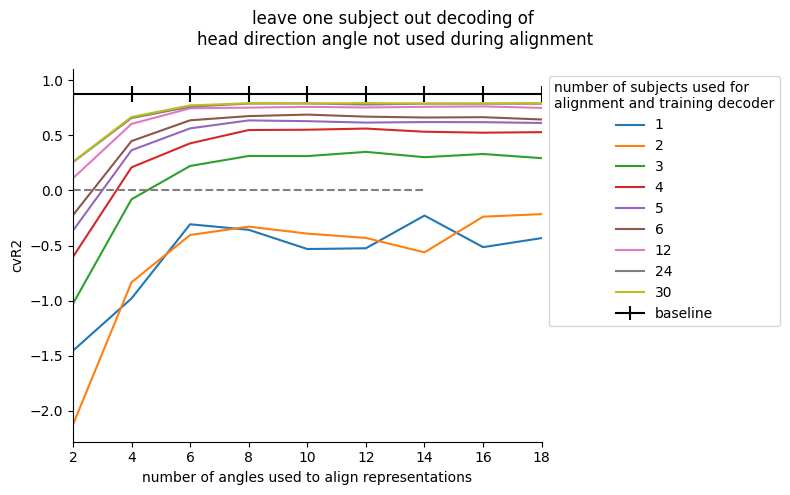

In [253]:
plt.figure(figsize=(8,5))
names = ["mean across subjects","median across subjects"]

[plt.plot(N_landmarks,np.median(np.median(all_foundations,0),0)[i],label=N_subjects[i]) for i in range(len(N_subjects))]


#[plt.fill_between(N_landmarks,np.percentile(all_foundations.mean(0),2.5,0)[i],np.percentile(all_foundations.mean(0),97.5,0)[i],alpha=0.1) for i in range(len(N_subjects))]
plt.errorbar(N_landmarks,np.median(np.median(all_baselines,0),0)*np.ones_like(N_landmarks),np.ones_like(N_landmarks)*np.std(np.median(all_baselines,1),0)/np.sqrt(S_tot//2),label='baseline',color='black')

plt.xlabel("number of angles used to align representations")
plt.ylabel ("cvR2")
#plt.ylim(-0.5,1)
#plt.yticks([0,1])
plt.plot([2,14],[0,0],'--',color='gray')
plt.legend(title="number of subjects used for \nalignment and training decoder",bbox_to_anchor=(1,1))
plt.suptitle("leave one subject out decoding of \nhead direction angle not used during alignment")
plt.tight_layout()
sns.despine()
plt.xlim(2,18)

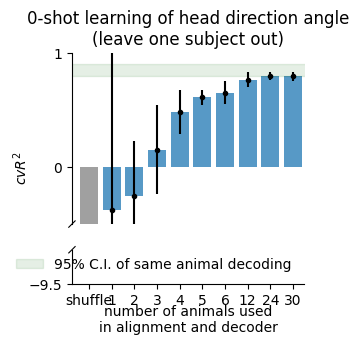

In [254]:
from brokenaxes import brokenaxes
plt.figure(figsize=(3,3))
bax = brokenaxes(ylims=((-9.5, -9.2), (-0.5, 1)),hspace=0.25)

bax.bar(range(9),np.median(np.median(all_foundations,1),0)[:,-1],alpha=0.75)
bax.bar(-1,np.median(shuffle_baselines),color='gray',alpha=0.75)

bax.errorbar(range(9),np.median(np.median(all_foundations,1),0)[:,-1],2*np.std(np.median(all_foundations,0),0)[:,-1],color='black',fmt='.')

ci_baseline_low = np.percentile(np.median(all_baselines,0),2.5)
ci_baseline_high = np.percentile(np.median(all_baselines,0),97.5)
bax.fill_between(np.arange(-4,9.5),ci_baseline_low,ci_baseline_high, alpha=0.1,color='darkgreen',label='95% C.I. of same animal decoding')

bax.set_xlabel("number of animals used\nin alignment and decoder")
bax.set_ylabel("$cvR^2$")
bax.set_title('0-shot learning of head direction angle\n(leave one subject out)')

bax.legend(loc='lower right',frameon=False)
bax.set_xlim(-1.75,8.5)
bax.set_xticks(range(-1,9),["shuffle"]+[str(n) for n in N_subjects])
bax.axs[0].set_yticks([0,1])
bax.axs[1].set_yticks([-9.5])
plt.savefig('../results/aligned_decoding_hd_angle.svg',bbox_inches='tight')
